In [2]:
import copy
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.collections import LineCollection
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

COLOR = "#83c9f4"
DEFAULT_BOUNDING_BOX_SCALE = 1.1


def koch_curve(order, size=1):
    def koch_curve_points(order):
        if order == 0:
            return np.array([[0, 0], [1, 0]])
        else:
            points = koch_curve_points(order - 1)
            n = len(points) - 1
            new_points = np.zeros((4 * n + 1, 2))
            new_points[0] = points[0]
            for i in range(n):
                a, b = points[i], points[i + 1]
                t = b - a
                c = a + t / 3
                d = a + t * 2 / 3
                e = a + np.dot(
                    t, np.array([[1 / 2, -np.sqrt(3) / 6], [np.sqrt(3) / 6, 1 / 2]])
                )
                new_points[4 * i + 1 : 4 * i + 5] = [c, e, d, b]
            return new_points

    curve = koch_curve_points(order) * size
    return curve


def koch_snowflake(order, size=1):
    curve = koch_curve(order, size)

    rot120 = np.array([[-1 / 2, -np.sqrt(3) / 2], [np.sqrt(3) / 2, -1 / 2]])
    rot240 = np.array([[-1 / 2, np.sqrt(3) / 2], [-np.sqrt(3) / 2, -1 / 2]])

    curve1 = np.dot(curve, rot120)
    curve2 = np.dot(curve, rot240)

    curve1 = curve1 + [size * np.cos(np.pi / 3), size * np.sin(np.pi / 3)]
    curve2 = curve2 + [size, 0]

    snowflake = np.vstack([curve1, curve[1:], curve2[1:]])

    return snowflake


def point_inside_polygon(point, polygon):
    x, y = point
    n = len(polygon)
    inside = False
    p1x, p1y = polygon[0]
    for i in range(n + 1):
        p2x, p2y = polygon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside


def get_bounding_box(snowflake, bounding_box_scale=DEFAULT_BOUNDING_BOX_SCALE):
    min_x, max_x = np.min(snowflake[:, 0]), np.max(snowflake[:, 0])
    min_y, max_y = np.min(snowflake[:, 1]), np.max(snowflake[:, 1])

    center_x, center_y = (min_x + max_x) / 2, (min_y + max_y) / 2
    width, height = max_x - min_x, max_y - min_y

    min_x = center_x - (width / 2) * bounding_box_scale
    max_x = center_x + (width / 2) * bounding_box_scale
    min_y = center_y - (height / 2) * bounding_box_scale
    max_y = center_y + (height / 2) * bounding_box_scale

    return min_x, max_x, min_y, max_y


def sample_labeled_points(n_points, depth, size=1, bounding_box_scale=DEFAULT_BOUNDING_BOX_SCALE):
    snowflake = koch_snowflake(depth, size)

    min_x, max_x, min_y, max_y = get_bounding_box(snowflake, bounding_box_scale)

    # Sample points
    points = np.random.uniform(
        low=[min_x, min_y], high=[max_x, max_y], size=(n_points, 2)
    )

    # Label points
    labels = np.array(
        [point_inside_polygon(point, snowflake) for point in points], dtype=int
    )

    return points, labels


def draw_koch_snowflake_with_points(order, points, labels, size=1):
    snowflake = koch_snowflake(order, size)

    plt.figure(figsize=(10, 10))

    # Plot snowflake
    plt.fill(snowflake[:, 0], snowflake[:, 1], COLOR, edgecolor="none", linewidth=0.5)

    # Plot points
    inside_points = points[labels == 1]
    outside_points = points[labels == 0]
    plt.scatter(inside_points[:, 0], inside_points[:, 1], c="white", s=1, alpha=0.5)
    plt.scatter(outside_points[:, 0], outside_points[:, 1], c="black", s=1, alpha=0.5)

    plt.axis("equal")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


RESULTS_DIR = Path(os.getcwd()) / "results"


# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Training routine
def train_model(model, dataloader, n_epochs, save_interval, grid):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    model_states = []
    predictions = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        if epoch % save_interval == 0 or epoch == n_epochs - 1:
            # Save model state
            model_states.append(copy.deepcopy(model.state_dict()))
            # Save predictions
            model.eval()
            with torch.no_grad():
                pred = (
                    model(grid.to(device))
                    .cpu()
                    .numpy()
                    .reshape(np.sqrt(grid.shape[0]).astype(int), -1)
                )
            predictions.append(pred)
    return model_states, predictions


def generate_plot(
    predictions,
    snowflake_segments,
    x_min,
    x_max,
    y_min,
    y_max,
    save_interval,
    is_full_snowflake,
    interval=200,
):
    fig, ax = plt.subplots(figsize=(10, 10))
    title = "Model Predictions During Training"
    ax.set_title(title)
    im = ax.imshow(
        predictions[0],
        extent=[x_min, x_max, y_min, y_max],
        origin="lower",
        cmap="viridis",
        alpha=0.8,
        animated=True,
    )

    line_collection = LineCollection(snowflake_segments, colors="red", linewidths=1.5)
    ax.add_collection(line_collection)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    fig.colorbar(im, label="Prediction")

    def update(frame):
        im.set_array(predictions[frame])
        ax.set_title(f"{title} (Epoch {frame * save_interval})")
        return (im,)

    anim = FuncAnimation(
        fig, update, frames=len(predictions), interval=interval, blit=True, repeat=False
    )

    filename = (
        "koch_snowflake_training.gif"
        if is_full_snowflake
        else "koch_curve_zoomed_training.gif"
    )
    writer = PillowWriter(fps=5)
    anim.save(RESULTS_DIR / filename, writer=writer)
    plt.close(fig)
    print(f"Animation saved as '{filename}'")


def segment_snowflake(snowflake, x_min, x_max, y_min, y_max):
    segments = []
    for i in range(len(snowflake) - 1):
        p1, p2 = snowflake[i], snowflake[i + 1]
        if (x_min <= p1[0] <= x_max and y_min <= p1[1] <= y_max) or (
            x_min <= p2[0] <= x_max and y_min <= p2[1] <= y_max
        ):
            segments.append([p1, p2])
    return segments


def create_animations(predictions, snowflake, size, save_interval, resolution):
    # Get the bounding box used for sampling points
    x_min, x_max, y_min, y_max = get_bounding_box(snowflake)

    snowflake_segments = segment_snowflake(snowflake, x_min, x_max, y_min, y_max)
    generate_plot(
        predictions, snowflake_segments, x_min, x_max, y_min, y_max, save_interval, True
    )

    # Zoomed plot (focusing on bottom third of snowflake)
    x_center = (x_min + x_max) / 2
    y_center = y_min + (y_max - y_min) / 6
    zoom_factor = 3
    x_range = (x_max - x_min) / zoom_factor
    y_range = (y_max - y_min) / zoom_factor

    x_min_zoom = x_center - x_range / 2
    x_max_zoom = x_center + x_range / 2
    y_min_zoom = y_center - y_range / 2
    y_max_zoom = y_center + y_range / 2

    # Calculate indices for cropping predictions
    x_start = int((x_min_zoom - x_min) / (x_max - x_min) * resolution)
    x_end = int((x_max_zoom - x_min) / (x_max - x_min) * resolution)
    y_start = int((y_min_zoom - y_min) / (y_max - y_min) * resolution)
    y_end = int((y_max_zoom - y_min) / (y_max - y_min) * resolution)

    # Crop predictions for zoomed view
    predictions_zoomed = [pred[y_start:y_end, x_start:x_end] for pred in predictions]

    # Segment snowflake for zoomed view
    snowflake_segments_zoomed = segment_snowflake(
        snowflake, x_min_zoom, x_max_zoom, y_min_zoom, y_max_zoom
    )

    generate_plot(
        predictions_zoomed,
        snowflake_segments_zoomed,
        x_min_zoom,
        x_max_zoom,
        y_min_zoom,
        y_max_zoom,
        save_interval,
        False,
    )

Using device: cuda


In [3]:
# Generate data
order = 3
n_points = 500
size = 1
bounding_box_scale = 1.2

points, labels = sample_labeled_points(n_points, order, size, bounding_box_scale)
snowflake = koch_snowflake(order, size)

In [28]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.layers(x)


# Convert data to PyTorch tensors
X = torch.FloatTensor(points).to(device)
y = torch.FloatTensor(labels).unsqueeze(1).to(device)

# Create DataLoader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize model
model = MLP().to(device)

RESOLUTION = 1000
# Prepare grid for predictions
x_min, x_max, y_min, y_max = get_bounding_box(snowflake)
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, RESOLUTION), np.linspace(y_min, y_max, RESOLUTION)
)
grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)

# Training parameters
n_epochs = 200
save_interval = 2

# Train model
model_states, predictions = train_model(
    model, dataloader, n_epochs, save_interval, grid
)


100%|██████████| 200/200 [00:44<00:00,  4.49it/s]


In [29]:
create_animations(predictions, snowflake, size, save_interval, RESOLUTION)

Animation saved as 'koch_snowflake_training.gif'
Animation saved as 'koch_curve_zoomed_training.gif'


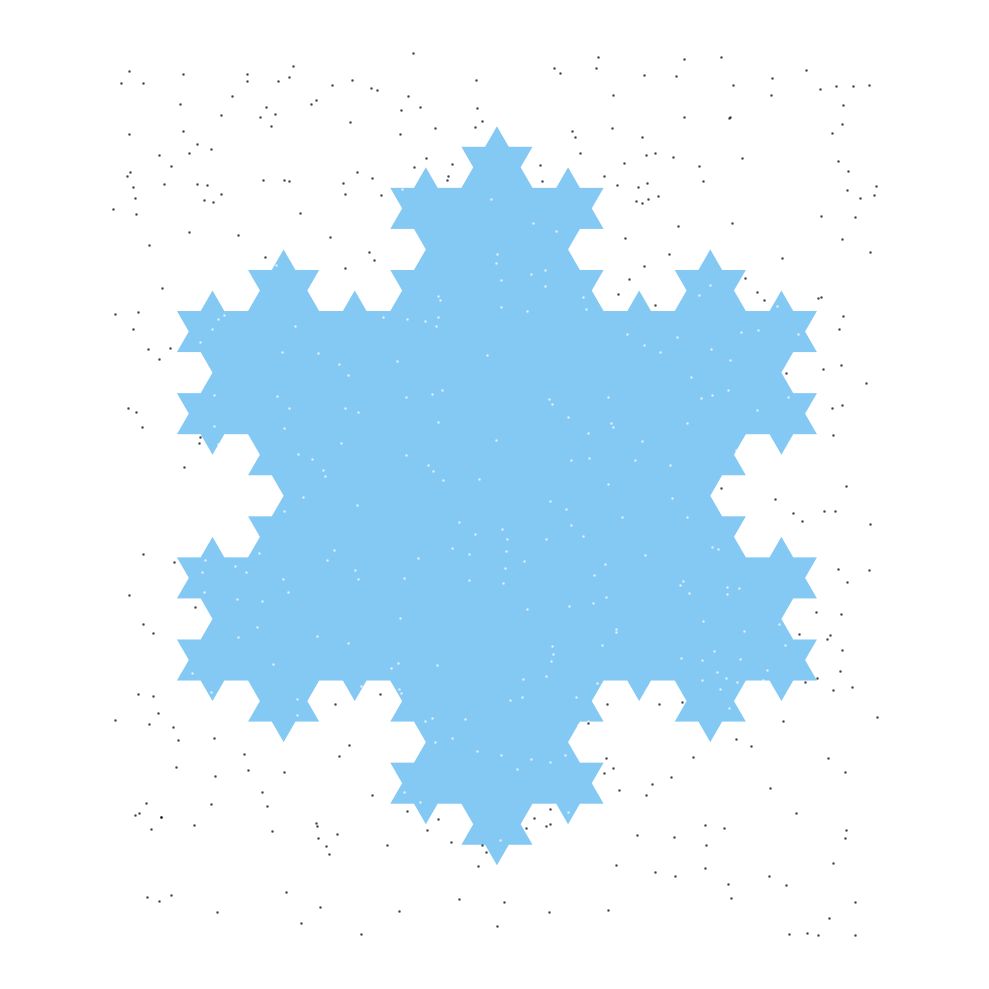

In [4]:
draw_koch_snowflake_with_points(3, points, labels)
# If you want to get the points and labels without plotting:
# points, labels = sample_labeled_points(n_points=10000, depth=3, bounding_box_scale=1.2)